In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import gower
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from tqdm import tqdm

In [2]:
df = pd.read_csv('/home/jupyter/clusters.csv').drop('Unnamed: 0', axis=1)
cluster = df[df.cluster==1]
print(cluster.shape)
cluster.head()

(9980, 26)


,artists,name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,release_date,year,medoid_0,medoid_1,medoid_2,medoid_3,cluster,genre,track_id,artist_id
1,['Martha Reeves & The Vandellas'],I Should Be Proud,0.166,0.417,176573,0.753,0,0.000000,9,0.2690,-10.204,0,33,0.1260,178.408,0.794,1970,1970,0.237460,0.175485,0.325105,0.310158,1,"['brill building pop', 'classic girl group', '...",2nxSAQBvF6gDIwZmG6B9nO,1Pe5hlKMCTULjosqZ6KanP
8,['Harry Nilsson'],The Town - Narration,0.830,0.732,89000,0.304,0,0.000002,9,0.2330,-19.752,0,27,0.4670,116.384,0.669,1970-12-01,1970,0.343313,0.237220,0.403132,0.282875,1,"['art rock', 'brill building pop', 'classic ro...",117rBB0OEexfRmf9h0tCl1,3RTzAwFprBqiskp550eSJX
12,['Anoushirvan Rohani'],Gole Sang,0.629,0.347,335334,0.528,0,0.000009,4,0.0761,-10.073,0,32,0.0393,122.678,0.385,1970,1970,0.268745,0.092882,0.347928,0.213215,1,"['classic persian pop', 'persian pop', 'persia...",7bl6zqSKHaCqKWmu6MMhp0,1EGCJLdTQxP8UIA4MWr6Nx
14,['John Denver'],Wooden Indian,0.753,0.710,99253,0.465,0,0.000000,11,0.1090,-7.492,0,30,0.0350,114.732,0.952,1971,1971,0.280431,0.174762,0.355425,0.244604,1,"['adult standards', 'classic country pop', 'fo...",2fANTvXPzQPJ9f1ojdd0Fo,7EK1bQADBoqbYXnT4Cqv9w
17,['Neil Diamond'],If You Go Away,0.903,0.315,228093,0.195,0,0.000721,2,0.1680,-16.265,0,40,0.0314,78.356,0.265,1971-11-05,1971,0.359627,0.255382,0.433684,0.261028,1,"['adult standards', 'brill building pop', 'fol...",3UZJXFe5Mmvby3mdZTfulm,7mEIug7XUlQHikrFxjTWes


# Preprocessing #

In [3]:
# create new data frame with only necessary features for modeling
model = cluster.drop(['artists', 'name', 'popularity', 'release_date', 'year', 'medoid_0', 'medoid_1', 'medoid_2', 
                      'medoid_3', 'cluster', 'genre', 'artist_id'], axis=1)
model.set_index('track_id', inplace=True)
print(model.shape)
model.head()

(9980, 13)


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
track_id,,,,,,,,,,,,,
2nxSAQBvF6gDIwZmG6B9nO,0.166,0.417,176573,0.753,0,0.000000,9,0.2690,-10.204,0,0.1260,178.408,0.794
117rBB0OEexfRmf9h0tCl1,0.830,0.732,89000,0.304,0,0.000002,9,0.2330,-19.752,0,0.4670,116.384,0.669
7bl6zqSKHaCqKWmu6MMhp0,0.629,0.347,335334,0.528,0,0.000009,4,0.0761,-10.073,0,0.0393,122.678,0.385
2fANTvXPzQPJ9f1ojdd0Fo,0.753,0.710,99253,0.465,0,0.000000,11,0.1090,-7.492,0,0.0350,114.732,0.952
3UZJXFe5Mmvby3mdZTfulm,0.903,0.315,228093,0.195,0,0.000721,2,0.1680,-16.265,0,0.0314,78.356,0.265


In [4]:
# create list for different types of features for access later
num_features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness',
                'speechiness', 'tempo', 'valence']
cat_features = ['explicit', 'mode', 'key']

### Calculate Matrix of Similarities Between All Tracks ###

In [5]:
# create a list of cat_features indicators
cat_ind = [True if x in cat_features else False for x in model.columns]

gdf = gower.gower_matrix(model, cat_features=cat_ind)

In [6]:
gdf_model = pd.DataFrame(gdf, index=model.index)
print(gdf_model.shape)
gdf_model.head()

(9980, 9980)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,9955,9956,9957,9958,9959,9960,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2nxSAQBvF6gDIwZmG6B9nO,0.000000,0.206914,0.221026,0.239119,0.303044,0.285888,0.180542,0.165993,0.257050,0.212059,0.214694,0.136887,0.169860,0.182581,0.222235,0.266130,0.224995,0.209882,0.216153,0.217332,0.172707,0.204925,0.197444,0.287757,0.243698,...,0.285528,0.240559,0.188392,0.285252,0.243687,0.217000,0.163908,0.202813,0.173480,0.164580,0.205517,0.218767,0.218621,0.286445,0.198758,0.123594,0.165253,0.097158,0.197889,0.259827,0.230714,0.297459,0.363365,0.192914,0.220018
117rBB0OEexfRmf9h0tCl1,0.206914,0.000000,0.245796,0.195142,0.230736,0.204935,0.242725,0.217191,0.266180,0.257030,0.316880,0.150166,0.271260,0.120245,0.252565,0.239286,0.245627,0.300261,0.340602,0.282219,0.273887,0.299776,0.306141,0.198215,0.327767,...,0.325331,0.243549,0.236156,0.179803,0.230113,0.264277,0.261741,0.288066,0.286956,0.269043,0.297996,0.242784,0.207951,0.365444,0.255610,0.217308,0.285561,0.164985,0.233665,0.299524,0.354064,0.307255,0.265483,0.280701,0.219252
7bl6zqSKHaCqKWmu6MMhp0,0.221026,0.245796,0.000000,0.184693,0.180300,0.192250,0.124505,0.104675,0.210316,0.164741,0.123293,0.174369,0.226967,0.179430,0.161803,0.157043,0.149803,0.102963,0.182113,0.139022,0.205130,0.265151,0.166445,0.248432,0.273793,...,0.165209,0.177140,0.126107,0.182673,0.217444,0.128444,0.205008,0.172741,0.214213,0.206671,0.168349,0.184588,0.229601,0.178150,0.169998,0.230396,0.285197,0.227924,0.201327,0.299773,0.222171,0.281195,0.260649,0.191350,0.137826
2fANTvXPzQPJ9f1ojdd0Fo,0.239119,0.195142,0.184693,0.000000,0.239611,0.228729,0.196219,0.151615,0.240030,0.223910,0.288598,0.125720,0.176338,0.193276,0.225949,0.232053,0.205631,0.232784,0.312212,0.218144,0.185559,0.218514,0.244618,0.303048,0.223267,...,0.272358,0.189128,0.180442,0.106241,0.172057,0.195685,0.176098,0.138024,0.228851,0.144144,0.179778,0.186989,0.212765,0.295090,0.198865,0.311186,0.245127,0.191613,0.157510,0.177538,0.288508,0.258367,0.293211,0.211438,0.169930
3UZJXFe5Mmvby3mdZTfulm,0.303044,0.230736,0.180300,0.239611,0.000000,0.153767,0.206426,0.264473,0.216292,0.202877,0.236094,0.261725,0.320044,0.203380,0.097906,0.149172,0.179071,0.226161,0.324193,0.306884,0.229858,0.356765,0.214110,0.175286,0.374129,...,0.321507,0.203787,0.271711,0.177920,0.264855,0.202116,0.293661,0.226796,0.297152,0.297231,0.329755,0.196010,0.273170,0.324360,0.230185,0.296273,0.367942,0.278688,0.273520,0.368965,0.257065,0.338729,0.247229,0.208657,0.200735


# Modeling #

In [59]:
np.random.seed(7046)

# find k clusters
results_kmedoids1 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 9980,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids1[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [03:30<00:00, 42.03s/it]


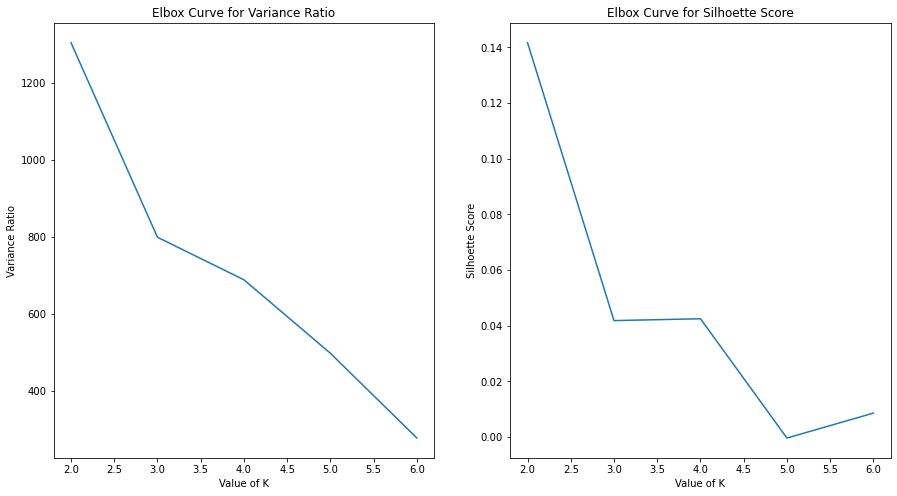

In [60]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids1.keys()],[i['v_ratio'] for i in results_kmedoids1.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids1.keys()],[i['s_score'] for i in results_kmedoids1.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [61]:
# save results for later and use in analysis notebook
results_all={}
results_all['model1'] = results_kmedoids1

In [62]:
np.random.seed(4594)

# find k clusters
results_kmedoids2 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids2[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [03:29<00:00, 41.93s/it]


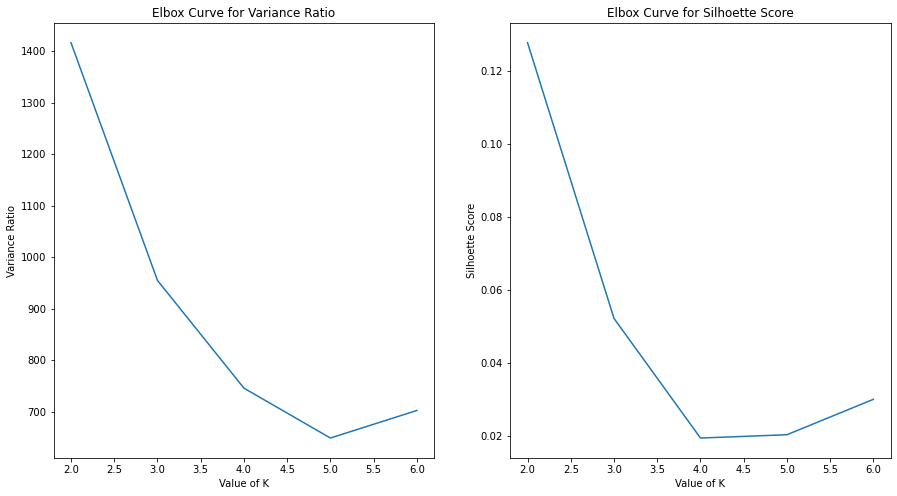

In [63]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids2.keys()],[i['v_ratio'] for i in results_kmedoids2.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids2.keys()],[i['s_score'] for i in results_kmedoids2.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [64]:
# save results for later and use in analysis notebook
results_all['model2'] = results_kmedoids2

In [65]:
np.random.seed(5141)

# find k clusters
results_kmedoids3 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids3[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [03:30<00:00, 42.00s/it]


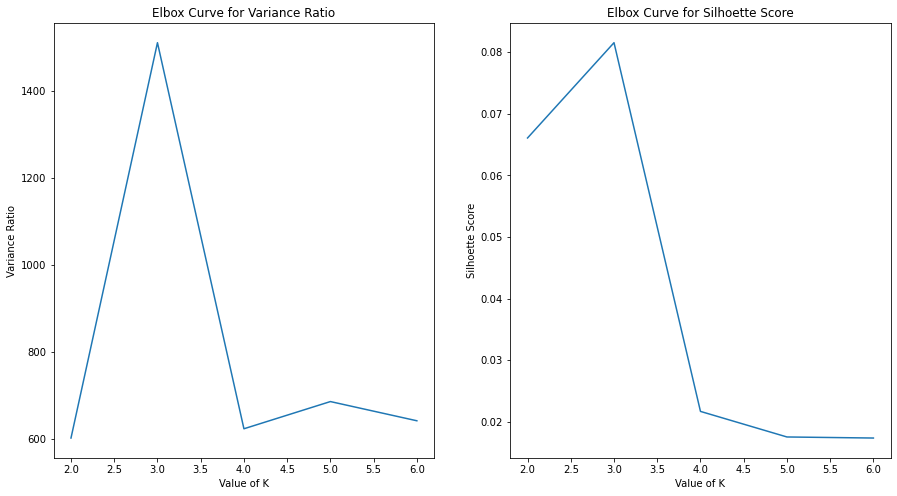

In [66]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids3.keys()],[i['v_ratio'] for i in results_kmedoids3.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids3.keys()],[i['s_score'] for i in results_kmedoids3.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [67]:
# save results for later and use in analysis notebook
results_all['model3'] = results_kmedoids3

In [44]:
np.random.seed(165)

# find k clusters
results_kmedoids4 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids4[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [03:29<00:00, 41.89s/it]


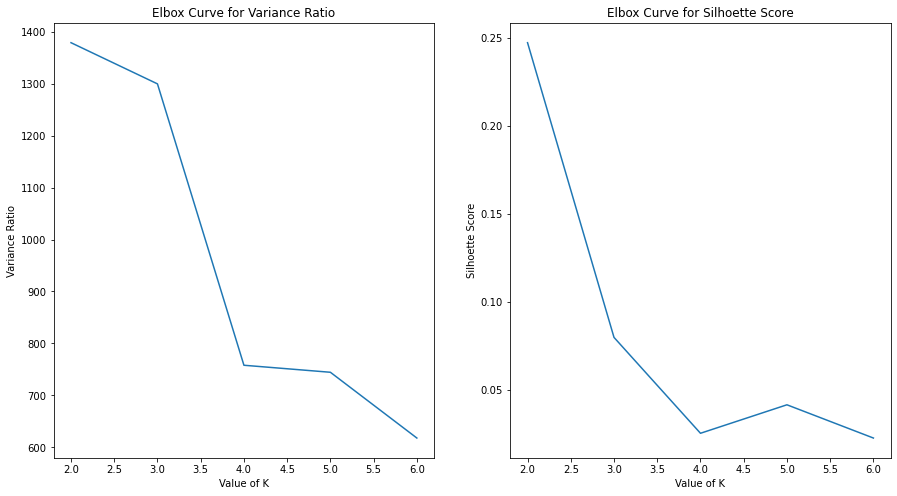

In [45]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids4.keys()],[i['v_ratio'] for i in results_kmedoids4.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids4.keys()],[i['s_score'] for i in results_kmedoids4.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [82]:
# save results for later and use in analysis notebook
results_all['model4'] = results_kmedoids4

In [20]:
np.random.seed(574)

# find k clusters
results_kmedoids5 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids5[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [03:36<00:00, 43.31s/it]


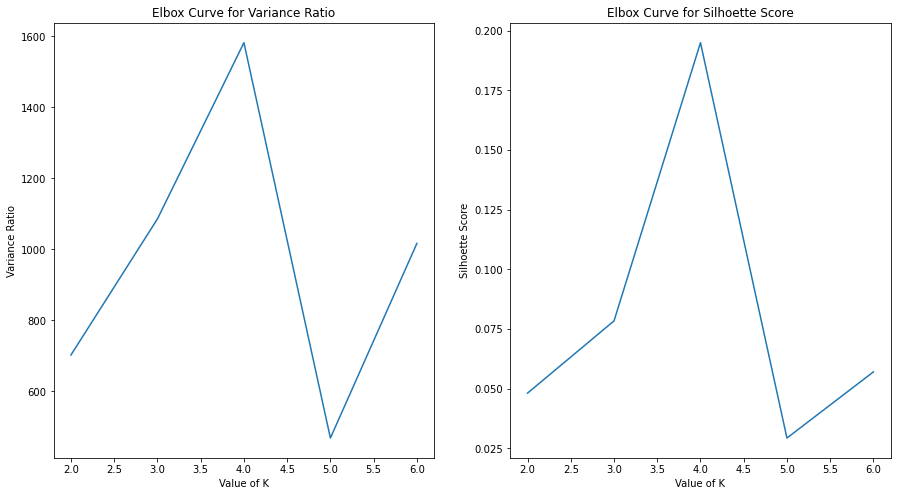

In [21]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids5.keys()],[i['v_ratio'] for i in results_kmedoids5.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids5.keys()],[i['s_score'] for i in results_kmedoids5.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [86]:
# save results for later and use in analysis notebook
results_all['model5'] = results_kmedoids5

Best model so far k=4.

In [68]:
np.random.seed(3973)

# find k clusters
results_kmedoids6 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids6[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [03:33<00:00, 42.61s/it]


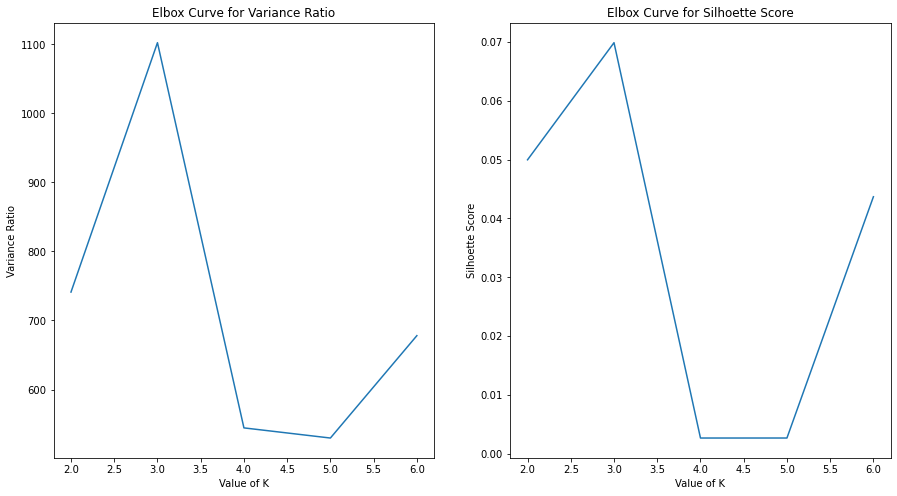

In [69]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids6.keys()],[i['v_ratio'] for i in results_kmedoids6.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids6.keys()],[i['s_score'] for i in results_kmedoids6.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [70]:
# save results for later and use in analysis notebook
results_all['model6'] = results_kmedoids6

In [26]:
np.random.seed(1137)

# find k clusters
results_kmedoids7 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids7[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [04:08<00:00, 49.78s/it]


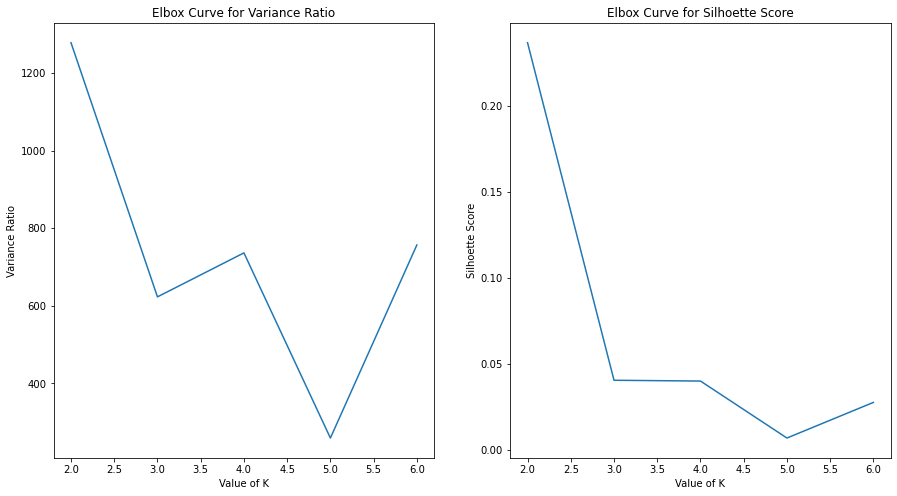

In [27]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids7.keys()],[i['v_ratio'] for i in results_kmedoids7.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids7.keys()],[i['s_score'] for i in results_kmedoids7.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [91]:
# save results for later and use in analysis notebook
results_all['model7'] = results_kmedoids7

In [71]:
np.random.seed(485)

# find k clusters
results_kmedoids8 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids8[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [03:28<00:00, 41.74s/it]


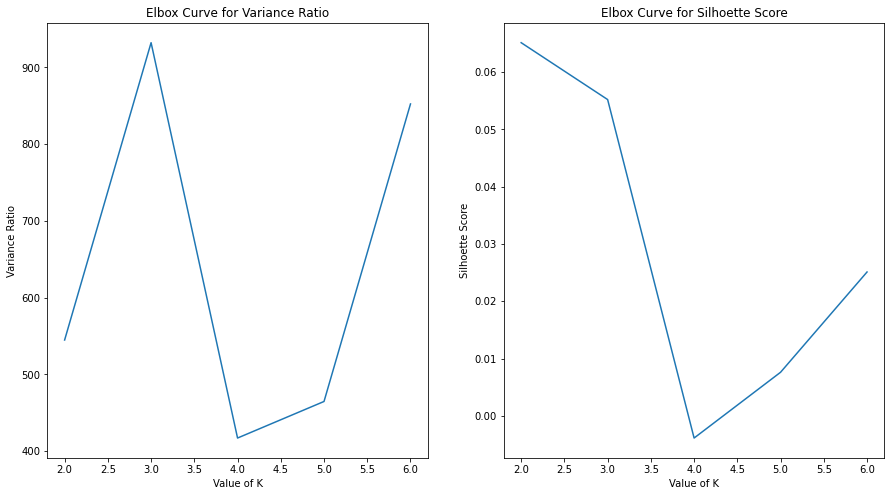

In [72]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids8.keys()],[i['v_ratio'] for i in results_kmedoids8.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids8.keys()],[i['s_score'] for i in results_kmedoids8.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [73]:
# save results for later and use in analysis notebook
results_all['model8'] = results_kmedoids8

In [74]:
np.random.seed(9134)

# find k clusters
results_kmedoids9 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids9[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [03:29<00:00, 41.86s/it]


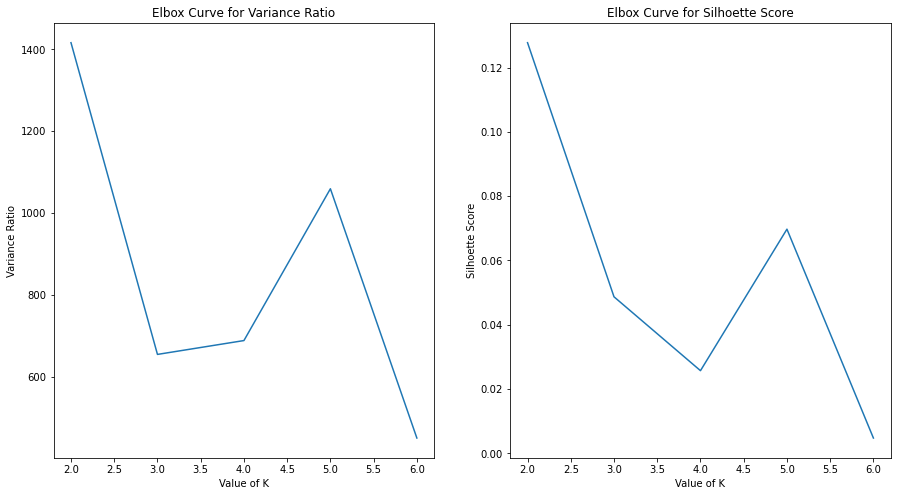

In [75]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids9.keys()],[i['v_ratio'] for i in results_kmedoids9.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids9.keys()],[i['s_score'] for i in results_kmedoids9.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [76]:
# save results for later and use in analysis notebook
results_all['model9'] = results_kmedoids9

In [77]:
np.random.seed(6650)

# find k clusters
results_kmedoids10 = dict()

k_cand = range(2, 7)

for k in tqdm(k_cand):
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0, 4765,size=k)
    kmedoids_instance = kmedoids(gdf_model, initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    v_ratio = calinski_harabasz_score(gdf_model, cluster_array)
    s_score = silhouette_score(gdf_model, cluster_array)
    
    # store
    results_kmedoids10[k] = {'clusters':cluster_array, 'medoids':medoids, 'v_ratio':v_ratio, 's_score':s_score}

100%|██████████| 5/5 [03:29<00:00, 41.87s/it]


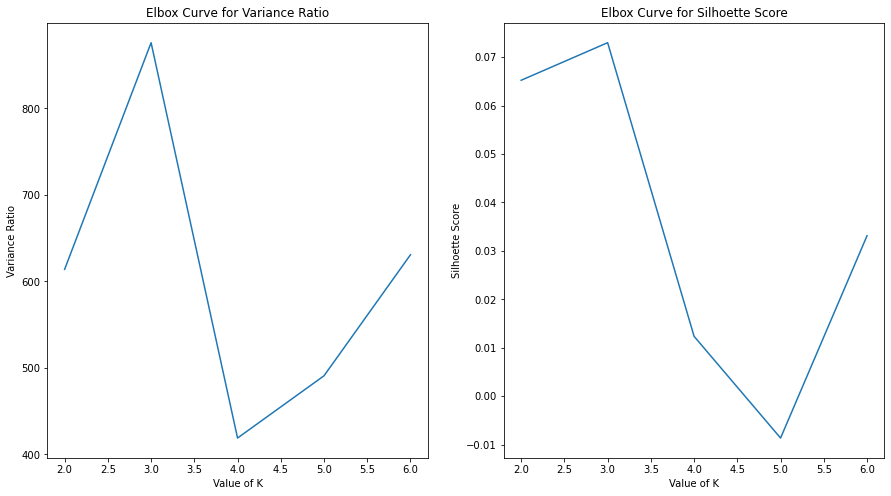

In [78]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

axs[0].plot([i for i in results_kmedoids10.keys()],[i['v_ratio'] for i in results_kmedoids10.values()])
axs[0].set_title('Elbox Curve for Variance Ratio')
axs[0].set_xlabel('Value of K')
axs[0].set_ylabel('Variance Ratio')
axs[1].plot([i for i in results_kmedoids10.keys()],[i['s_score'] for i in results_kmedoids10.values()])
axs[1].set_title('Elbox Curve for Silhoette Score')
axs[1].set_xlabel('Value of K')
axs[1].set_ylabel('Silhoette Score')
plt.show()

In [79]:
# save results for later and use in analysis notebook
results_all['model10'] = results_kmedoids10

# Conlusions #

In [110]:
cluster.iloc[[4030, 4659, 6067, 5684]]

,artists,name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,release_date,year,medoid_0,medoid_1,medoid_2,medoid_3,cluster,genre,track_id,artist_id
14693,['Faith Hill'],The Secret of Life,0.3450,0.609,254747,0.698,0,0.0,4,0.182,-7.575,1,34,0.0397,117.807,0.627,1998-04-10,1998,0.127778,0.103685,0.211454,0.152001,1,"['contemporary country', 'country', 'country d...",5wYgJcEdKam1nYSybFuOIe,25NQNriVT2YbSW80ILRWJa
16844,['The Cab'],Disturbia,0.0327,0.642,241800,0.749,0,0.0,11,0.114,-5.287,0,43,0.0364,124.997,0.693,2009,2009,0.174823,0.117968,0.281052,0.264036,1,"['modern rock', 'neon pop punk', 'pop punk', '...",1WzfIFQelHkxgxPotXkznf,2C2sVVXanbOpymYBMpsi89
21887,['Electric Light Orchestra'],It's Over,0.5710,0.637,248867,0.497,0,0.0,2,0.116,-10.604,0,49,0.0304,111.429,0.435,1977,1977,0.258559,0.138253,0.319307,0.181184,1,"['album rock', 'art rock', 'beatlesque', 'bow ...",4vmTtO8qFF9StEVeQ1KftR,7jefIIksOi1EazgRTfW2Pk
20528,['Case'],Happily Ever After,0.1380,0.747,276000,0.609,1,0.0,4,0.105,-6.985,0,54,0.0347,120.051,0.555,1999-01-01,1999,0.282390,0.103643,0.182147,0.315415,1,"['dance pop', 'hip hop', 'hip pop', 'neo soul'...",21fXrzSxu2y51Yqf57QycI,5aEWnrN8h3MhuFUPRfaVuy


In [117]:
medoids = gdf_model.iloc[[4030, 4659, 6067, 5684]].T
medoids['cluster2'] = results_all['model5'][4]['clusters']
medoids.columns = ['medoid2_0', 'medoid2_1', 'medoid2_2', 'medoid2_3', 'subcluster']
medoids.index = cluster.track_id

In [118]:
temp = cluster.set_index('track_id')
temp = temp.merge(medoids, left_index=True, right_index=True)

In [125]:
temp[temp.subcluster==0].sort_values('medoid2_0').head()

,artists,name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,release_date,year,medoid_0,medoid_1,medoid_2,medoid_3,cluster,genre,artist_id,medoid2_0,medoid2_1,medoid2_2,medoid2_3,subcluster
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5wYgJcEdKam1nYSybFuOIe,['Faith Hill'],The Secret of Life,0.345,0.609,254747,0.698,0,0.000000,4,0.1820,-7.575,1,34,0.0397,117.807,0.627,1998-04-10,1998,0.127778,0.103685,0.211454,0.152001,1,"['contemporary country', 'country', 'country d...",25NQNriVT2YbSW80ILRWJa,0.000000,0.203927,0.219539,0.203181,0
3pjuxHdoOS3p0E3lz8jfsD,['Mike & The Mechanics'],Word of Mouth - Remastered Version Edit,0.375,0.644,234960,0.756,0,0.000069,4,0.1920,-9.490,1,35,0.0291,105.017,0.516,1991-04-02,1991,0.147251,0.117158,0.215914,0.145207,1,"['album rock', 'art rock', 'classic rock', 'cl...",2yTUYhIf8fxptTIy3KLuJD,0.030565,0.219758,0.207582,0.215842,0
4BTPzhEsyW3blWcxcuhLM0,"['Shankar-Ehsaan-Loy', 'Shankar Mahadevan', 'C...",Mitwa,0.295,0.630,382973,0.630,0,0.000013,4,0.0934,-7.525,1,57,0.0364,107.103,0.517,2006-06-08,2006,0.140650,0.098906,0.208916,0.141780,1,"['desi hip hop', 'desi pop', 'filmi', 'modern ...",0L5GV6LN8SWWUWIdBbTLTZ,0.035441,0.216670,0.207183,0.191618,0
49YhoMIy1edjHKXNCfVErb,['Guster'],What You Wish For,0.190,0.625,230440,0.630,0,0.000007,4,0.0784,-7.305,1,33,0.0273,104.987,0.619,1999-09-16,1999,0.123380,0.096699,0.208281,0.156179,1,"['boston rock', 'indie pop', 'modern rock', 'n...",34XlPCFfB4vT7P1ekWq9Jc,0.035569,0.199706,0.222508,0.186301,0
3LSRGvBWTdnUBJC32oBFnZ,['Gian Marco'],Te Mentiría,0.266,0.748,227800,0.718,0,0.000000,4,0.2410,-8.131,1,54,0.0612,100.001,0.627,1998-09-03,1998,0.144448,0.117387,0.205335,0.178810,1,"['latin', 'latin pop', 'peruvian rock', 'pop p...",2gDqGAadPIPiA7LtmNn74g,0.035944,0.218309,0.242262,0.203895,0


In [129]:
temp[temp.subcluster==1].sort_values('medoid2_1').head()

,artists,name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,release_date,year,medoid_0,medoid_1,medoid_2,medoid_3,cluster,genre,artist_id,medoid2_0,medoid2_1,medoid2_2,medoid2_3,subcluster
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1WzfIFQelHkxgxPotXkznf,['The Cab'],Disturbia,0.03270,0.642,241800,0.749,0,0.000000,11,0.1140,-5.287,0,43,0.0364,124.997,0.693,2009,2009,0.174823,0.117968,0.281052,0.264036,1,"['modern rock', 'neon pop punk', 'pop punk', '...",2C2sVVXanbOpymYBMpsi89,0.203927,0.000000,0.176729,0.199962,1
5gtjm4ZrsGUGUwzXsB4zCw,['Modest Mouse'],Paper Thin Walls,0.07750,0.588,181267,0.793,0,0.000084,11,0.1330,-5.770,0,46,0.0363,126.670,0.682,2000-06-13,2000,0.168179,0.123569,0.281972,0.265527,1,"['alternative rock', 'dance-punk', 'double dru...",1yAwtBaoHLEDWAnWR87hBT,0.202072,0.017308,0.182193,0.206574,1
3tfLZpDj6oHXktYC5yS5TV,"['Jax Jones', 'Ina Wroldsen']",Breathe,0.01090,0.695,213747,0.820,0,0.000142,11,0.0605,-4.985,0,0,0.0428,125.881,0.653,2020-06-12,2020,0.178789,0.129349,0.283936,0.276729,1,"['dance pop', 'edm', 'house', 'pop', 'pop rap'...",4Q6nIcaBED8qUel8bBx6Cr,0.218470,0.021340,0.191872,0.204851,1
6bnVMdZObpNPUJ0vVFzkGn,"['Jax Jones', 'Ina Wroldsen']",Breathe,0.01090,0.695,213747,0.820,0,0.000142,11,0.0605,-4.985,0,0,0.0428,125.881,0.653,2020-06-12,2020,0.178789,0.129349,0.283936,0.276729,1,"['dance pop', 'edm', 'house', 'pop', 'pop rap'...",4Q6nIcaBED8qUel8bBx6Cr,0.218470,0.021340,0.191872,0.204851,1
0HtM9aNFkEwd6alO0av3Qq,['MARINA'],Radioactive,0.00584,0.692,226963,0.774,0,0.000000,11,0.0467,-4.308,0,43,0.0327,125.970,0.621,2012-04-30,2012,0.183779,0.126377,0.281928,0.272669,1,"['dance pop', 'electropop', 'indie pop', 'metr...",6CwfuxIqcltXDGjfZsMd9A,0.216030,0.022328,0.187230,0.201073,1


In [128]:
temp[temp.subcluster==2].sort_values('medoid2_2').head()

,artists,name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,release_date,year,medoid_0,medoid_1,medoid_2,medoid_3,cluster,genre,artist_id,medoid2_0,medoid2_1,medoid2_2,medoid2_3,subcluster
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4vmTtO8qFF9StEVeQ1KftR,['Electric Light Orchestra'],It's Over,0.571,0.637,248867,0.497,0,0.0,2,0.1160,-10.604,0,49,0.0304,111.429,0.435,1977,1977,0.258559,0.138253,0.319307,0.181184,1,"['album rock', 'art rock', 'beatlesque', 'bow ...",7jefIIksOi1EazgRTfW2Pk,0.219539,0.176729,0.000000,0.228086,2
24UBqV1xJwNUns7nJVIbDu,['Isabel Pantoja'],Marinero de Luces,0.612,0.582,182827,0.411,0,0.0,2,0.1290,-11.997,0,52,0.0884,116.568,0.462,1985,1985,0.264314,0.154694,0.326134,0.187256,1,"['cancion melodica', 'copla', 'pop romantico',...",0G2qO3Wbj6WmCTFgcsJ1Eo,0.232298,0.196376,0.030042,0.248463,2
0wgzc8MG84GvIzSY59MuTN,['Amanda Miguel'],Las Pequeñas Cosas,0.519,0.692,236487,0.617,0,0.0,2,0.0854,-8.688,0,48,0.0320,123.483,0.444,1984-01-01,1984,0.239809,0.125738,0.294191,0.198539,1,"['grupera', 'latin', 'latin pop', 'ranchera']",3v8mFhjLFa50QK8zDvAMYN,0.208400,0.158831,0.031041,0.205226,2
7cm9QkrwSWH0scegcO8XZ2,['Cher'],I Found Someone,0.557,0.538,223160,0.604,0,0.0,2,0.1620,-10.936,0,53,0.0262,102.839,0.373,1987-01-01,1987,0.254232,0.150307,0.328288,0.195484,1,"['dance pop', 'hollywood', 'new wave pop', 'pop']",72OaDtakiy6yFqkt4TsiFt,0.220785,0.189436,0.031771,0.241214,2
2OA0iq9hGkvUcS5qA1ZJnU,['Mary J. Blige'],Not Gon' Cry,0.664,0.758,294267,0.424,0,0.0,2,0.0950,-8.935,0,51,0.0468,110.087,0.455,1997-01-01,1997,0.275862,0.155518,0.321090,0.200836,1,"['dance pop', 'hip pop', 'neo soul', 'pop', 'r...",1XkoF8ryArs86LZvFOkbyr,0.240402,0.197396,0.033102,0.228512,2


After attempting to create subclusters, the cluster were worse. They were less consitent with the sound they were capturing and the genres were even more mixed up. I believe it's the nature of the algorithm and the use of gowers distance that makes reclustering an already clustered group difficult. The results produced are not necesssarily better than the first time they were clustered. Perhaps it is also the nature of the data itself that makes clustering by subgenre difficult as the tracks are being clustered based on sound but by the features of the tracks.